# Generative AI Tools & Platforms 2025 — Openness, Ecosystem, and Baseline Models

This notebook is a compact analytics lab for the 2025 Generative AI ecosystem:  
who is building tools, how the landscape is shifting, and what drives **open vs closed** platforms.

We focus on three core questions:

1. **Ecosystem:** How have GenAI tools grown over time, which categories and modalities dominate, and who are the main vendors?  
2. **Openness:** How does the share of open-source tools vary by year and by category?  
3. **Prediction:** Given a tool's category, modality, age, and meta fields, can we reliably predict whether it is `open_source`?

Along the way you get:

- A clean, reproducible audit of the dataset  
- Focused visual EDA using Matplotlib & Seaborn  
- Cross-validated baseline models (Logistic Regression, Random Forest, HistGradientBoosting)  
- Interpretable signals that connect **data → model → openness insights → decisions**


## 1. Setup & Imports

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown, display

# Core packages
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.base import clone

# Reproducibility
RANDOM_SEED = 42
N_FOLDS = 5
np.random.seed(RANDOM_SEED)

# Visualization defaults
sns.set_theme(style="whitegrid", palette="Blues")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.grid"] = True

display(Markdown("Environment ready — imports, style, and seed set."))


Environment ready — imports, style, and seed set.

## 2. Load the dataset — first look at the data

We start by loading the **Generative AI Tools & Platforms 2025** dataset from Kaggle and running a quick structural check:

- Overall shape (rows × columns)  
- A few sample rows to see how records look  
- Data types for each column  
- Missing values across the table  

This gives us a fast sanity check on data quality before we move into cleaning, EDA, and modeling.


In [2]:
# Path to the dataset 
DATA_PATH = "/kaggle/input/generative-ai-tools-and-platforms-2025/Generative AI Tools - Platforms 2025.csv"
REF_YEAR = 2025  # fixed reference year for reproducibility


def load_data(path: str) -> pd.DataFrame:
    """Load the GenAI tools dataset and print a lightweight audit."""
    df = pd.read_csv(path)
    print(f"Loaded dataset from: {path}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    display(Markdown("### Sample rows"))
    display(df.head(5))

    display(Markdown("### Data types"))
    display(df.dtypes.to_frame("dtype").T)

    missing = df.isna().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    if len(missing):
        display(Markdown("### Missing values (non-zero)"))
        display(missing.to_frame("missing_values"))
    else:
        print("No missing values detected.")

    return df


df_raw = load_data(DATA_PATH)

Loaded dataset from: /kaggle/input/generative-ai-tools-and-platforms-2025/Generative AI Tools - Platforms 2025.csv
Shape: 113 rows × 22 columns



### Sample rows

,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
0,ChatGPT,OpenAI,LLMs & Chat Assistants,multimodal,0,1,api,https://chatgpt.com,chatgpt.com,2022,...,0,0,0,0,0,0,0,0,1,0
1,Claude,Anthropic,LLMs & Chat Assistants,multimodal,0,1,api,https://claude.ai,claude.ai,2023,...,0,0,0,0,0,0,0,0,1,0
2,Gemini,Google,LLMs & Chat Assistants,multimodal,0,1,api,https://gemini.google.com,gemini.google.com,2023,...,0,0,0,0,0,0,0,0,1,0
3,Midjourney,Midjourney,Image Gen & Editing,image,0,0,unavailable,https://www.midjourney.com,midjourney.com,2022,...,1,0,0,0,0,0,0,0,0,1
4,Stable Diffusion,Stability AI,Image Gen & Editing,image,1,1,api,https://stability.ai/stable-image,stability.ai,2022,...,1,0,0,0,0,0,0,0,0,1


### Data types

,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
dtype,object,object,object,object,int64,int64,object,object,object,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


No missing values detected.


## 3. Cleaning & Feature Engineering — turning raw entries into usable signals

The raw table is already informative, but we want it to be **clean, consistent, and model-ready**. In this step we:

- Normalize text columns (strip whitespace) so categories and names behave consistently  
- Convert binary flags to proper numeric fields (`0/1` for `open_source`, `api_available`)  
- Ensure `release_year` is numeric and derive `years_since_release` as a simple age measure  
- Build `modality_count` and a coarse `age_bucket` to make patterns easier to analyze and model

The idea is to keep the transformations **minimal but explicit** so the same logic can be reused for both EDA and downstream modeling.


In [3]:
def clean_and_engineer(df: pd.DataFrame, ref_year: int = REF_YEAR) -> pd.DataFrame:
    """Clean text, normalize binary flags, and engineer simple, reusable features."""
    df = df.copy()

    # 1. Trim whitespace in object columns
    text_cols = df.select_dtypes(include="object").columns
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip()

    # 2. Binary flags → numeric 0/1
    for col in ["open_source", "api_available"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    # 3. Ensure release_year is numeric
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

    # 4. Modality count
    if "modality_count" not in df.columns:
        mod_cols = [c for c in df.columns if c.lower().startswith("mod_")]
        if mod_cols:
            df[mod_cols] = df[mod_cols].fillna(0).astype(int)
            df["modality_count"] = df[mod_cols].sum(axis=1)
        elif "modality_canonical" in df.columns:
            def _count_modalities(s):
                if pd.isna(s):
                    return 0
                tokens = [
                    t.strip()
                    for t in str(s).replace("|", ",").replace(";", ",").split(",")
                    if t.strip()
                ]
                return len(set(tokens))
            df["modality_count"] = df["modality_canonical"].apply(_count_modalities)
        else:
            df["modality_count"] = 0

    # 5. Years since release (fixed reference year for reproducibility)
    if "release_year" in df.columns and "years_since_release" not in df.columns:
        df["years_since_release"] = (ref_year - df["release_year"].fillna(ref_year)).astype(int)

    # 6. Simple age bucket for interpretable EDA
    if "years_since_release" in df.columns:
        bins = [-1, 1, 3, 7, 50]
        labels = ["<=1y", "1–3y", "3–7y", "7y+"]
        df["age_bucket"] = pd.cut(df["years_since_release"], bins=bins, labels=labels)

    return df


df = clean_and_engineer(df_raw, ref_year=REF_YEAR)
print(f"Cleaned dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

display(Markdown("### Cleaned sample (first 5 rows)"))
display(df.head(5))

Cleaned dataset shape: 113 rows × 23 columns


### Cleaned sample (first 5 rows)

,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count,age_bucket
0,ChatGPT,OpenAI,LLMs & Chat Assistants,multimodal,0,1,api,https://chatgpt.com,chatgpt.com,2022,...,0,0,0,0,0,0,0,1,0,1–3y
1,Claude,Anthropic,LLMs & Chat Assistants,multimodal,0,1,api,https://claude.ai,claude.ai,2023,...,0,0,0,0,0,0,0,1,0,1–3y
2,Gemini,Google,LLMs & Chat Assistants,multimodal,0,1,api,https://gemini.google.com,gemini.google.com,2023,...,0,0,0,0,0,0,0,1,0,1–3y
3,Midjourney,Midjourney,Image Gen & Editing,image,0,0,unavailable,https://www.midjourney.com,midjourney.com,2022,...,0,0,0,0,0,0,0,0,1,1–3y
4,Stable Diffusion,Stability AI,Image Gen & Editing,image,1,1,api,https://stability.ai/stable-image,stability.ai,2022,...,0,0,0,0,0,0,0,0,1,1–3y


## 4. Target: `open_source` — label overview

Our target is the binary flag **`open_source`**  
(`0` = closed-source, `1` = open-source).

Here we inspect its class distribution to see how balanced the problem is
and to understand how to read metrics like accuracy and Macro-F1.


### Class distribution — `open_source`

,count,ratio
open_source,,
0,71,0.628
1,42,0.372


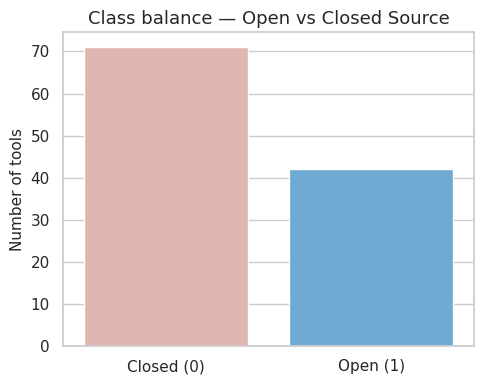

Both classes are well represented, with a slight dominance of closed-source tools — this is a comfortable setup for baseline modeling.

In [4]:
TARGET = "open_source"
assert TARGET in df.columns, f"Target column '{TARGET}' is not present."

y = df[TARGET].astype(int)

display(Markdown("### Class distribution — `open_source`"))
class_counts = y.value_counts().reindex([0, 1]).fillna(0).astype(int)
class_ratio = (class_counts / class_counts.sum()).round(3)
display(pd.DataFrame({"count": class_counts, "ratio": class_ratio}))

plt.figure(figsize=(5, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=["#E6B0AA", "#5DADE2"])
plt.title("Class balance — Open vs Closed Source")
plt.xticks([0, 1], ["Closed (0)", "Open (1)"])
plt.ylabel("Number of tools")
plt.xlabel("")
plt.tight_layout()
plt.show()

display(Markdown(
    "Both classes are well represented, with a slight dominance of closed-source tools — "
    "this is a comfortable setup for baseline modeling."
))

## 5. Ecosystem EDA — how is the GenAI world structured?

Here we map the GenAI landscape:

- Releases over time (when tools appeared)  
- Open-source share by year and by category  
- Dominant categories and modalities  
- Modality co-occurrence patterns  
- Market share of leading companies  

This gives a high-level picture before we move into modeling.


### EDA views

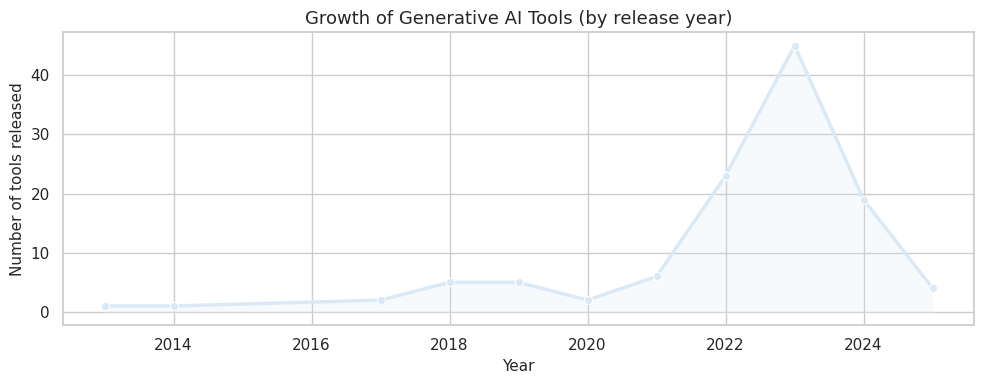

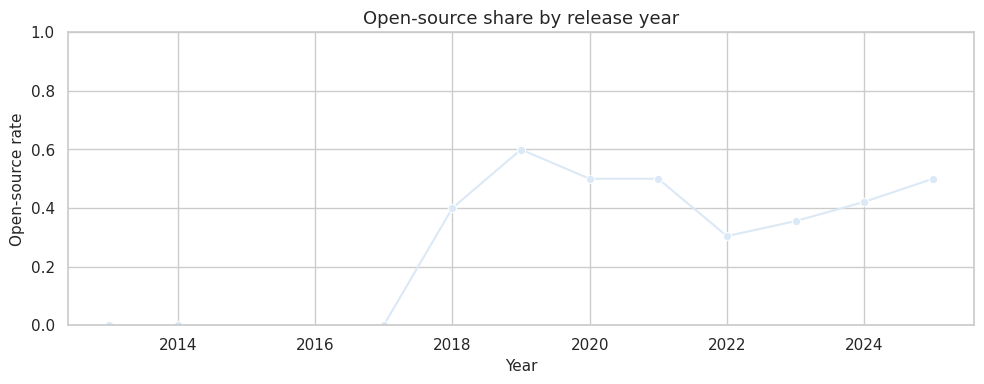

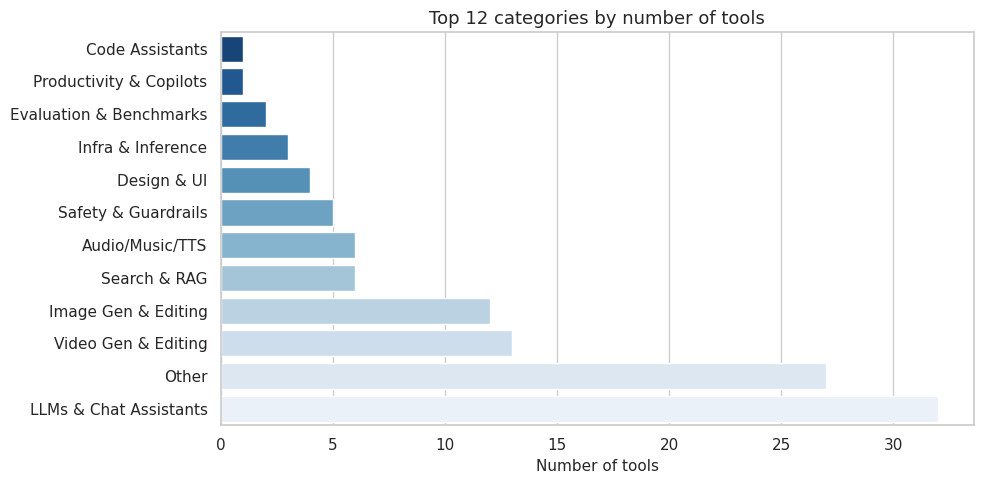

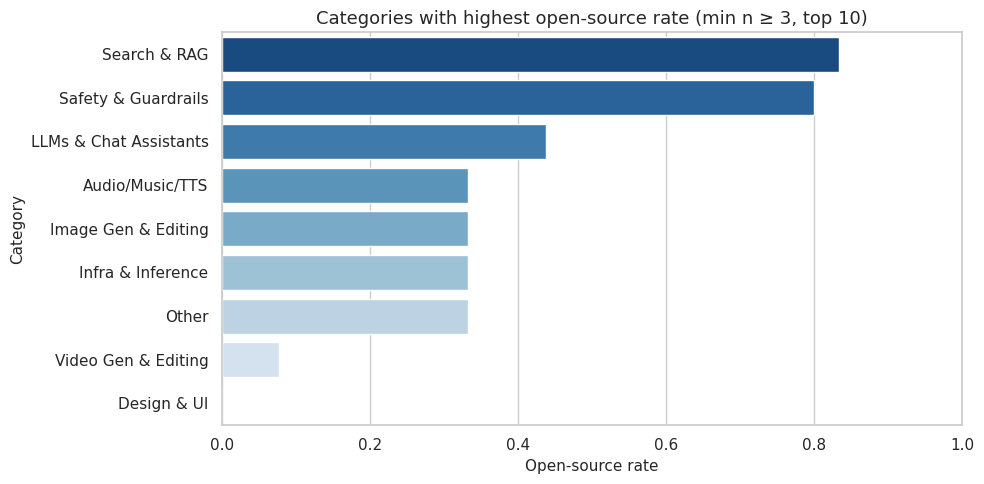

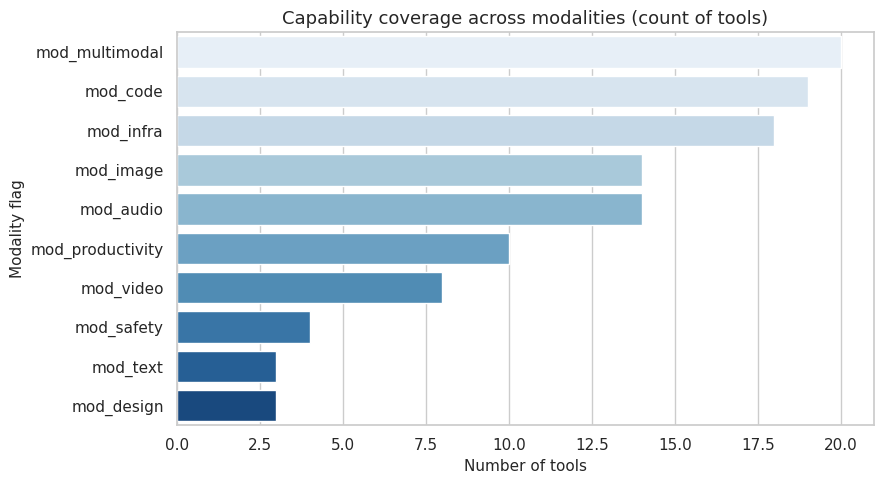

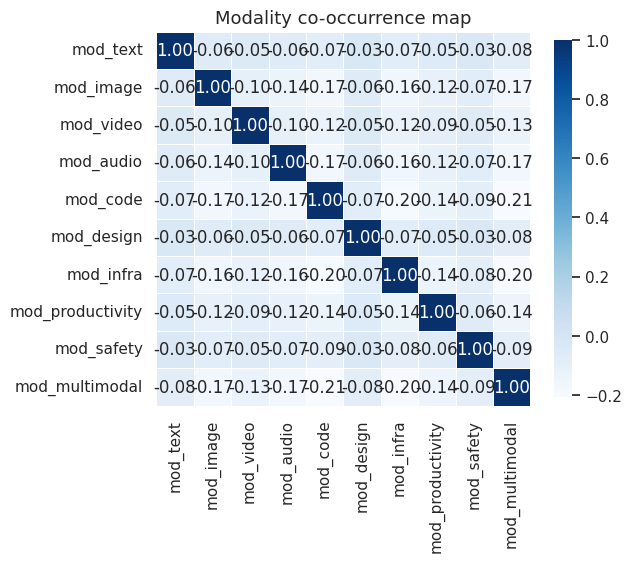

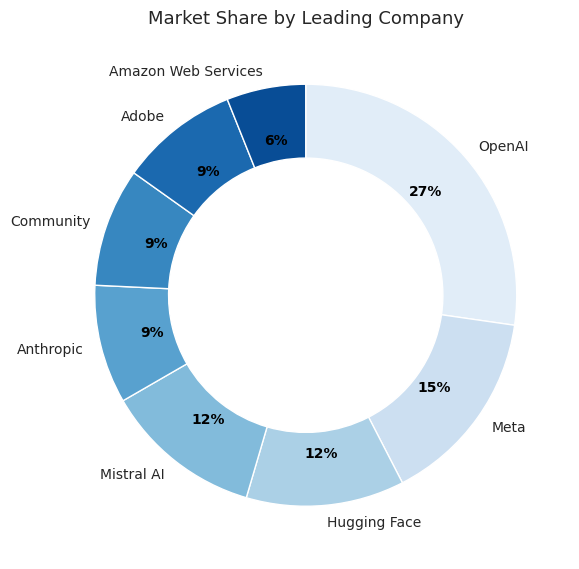

In [5]:
def plot_releases_per_year(df: pd.DataFrame) -> None:
    if "release_year" not in df.columns:
        return

    yearly = df["release_year"].dropna().value_counts().sort_index()
    if len(yearly) == 0:
        return

    plt.figure(figsize=(10, 4))
    sns.lineplot(x=yearly.index, y=yearly.values, marker="o", linewidth=2.5)
    plt.fill_between(yearly.index, yearly.values, alpha=0.2)
    plt.title("Growth of Generative AI Tools (by release year)")
    plt.xlabel("Year")
    plt.ylabel("Number of tools released")
    plt.tight_layout()
    plt.show()


def plot_open_source_rate_by_year(df: pd.DataFrame) -> None:
    if not {"release_year", TARGET}.issubset(df.columns):
        return

    rate = (
        df.dropna(subset=["release_year"])
          .groupby("release_year")[TARGET]
          .mean()
          .sort_index()
    )
    if len(rate) == 0:
        return

    plt.figure(figsize=(10, 4))
    sns.lineplot(x=rate.index, y=rate.values, marker="o")
    plt.title("Open-source share by release year")
    plt.xlabel("Year")
    plt.ylabel("Open-source rate")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


def plot_top_categories(df: pd.DataFrame, top_n: int = 10) -> None:
    col = "category_canonical"
    if col not in df.columns:
        return

    counts = df[col].value_counts().head(top_n).sort_values(ascending=True)

    plt.figure(figsize=(10, 5))
    sns.barplot(y=counts.index, x=counts.values, palette="Blues_r")
    plt.title(f"Top {top_n} categories by number of tools")
    plt.xlabel("Number of tools")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


def plot_open_share_by_category(df: pd.DataFrame, top_n: int = 10) -> None:
    if not {"category_canonical", TARGET}.issubset(df.columns):
        return

    cat_stats = (
        df.groupby("category_canonical")[TARGET]
          .agg(["mean", "count"])
          .rename(columns={"mean": "open_rate", "count": "n"})
    )
    cat_stats = cat_stats[cat_stats["n"] >= 3]
    cat_stats = cat_stats.sort_values("open_rate", ascending=False).head(top_n)

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=cat_stats,
        x="open_rate",
        y=cat_stats.index,
        palette="Blues_r",
    )
    plt.title(f"Categories with highest open-source rate (min n ≥ 3, top {top_n})")
    plt.xlabel("Open-source rate")
    plt.ylabel("Category")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


def plot_modality_coverage(df: pd.DataFrame) -> None:
    mod_cols = [c for c in df.columns if c.lower().startswith("mod_")]
    if not mod_cols:
        return

    mod_sum = df[mod_cols].fillna(0).astype(int).sum().sort_values(ascending=False)

    plt.figure(figsize=(9, 5))
    sns.barplot(x=mod_sum.values, y=mod_sum.index, palette="Blues")
    plt.title("Capability coverage across modalities (count of tools)")
    plt.xlabel("Number of tools")
    plt.ylabel("Modality flag")
    plt.tight_layout()
    plt.show()

    if len(mod_cols) >= 2:
        corr = df[mod_cols].corr()
        plt.figure(figsize=(6.5, 6))
        sns.heatmap(
            corr,
            cmap="Blues",
            annot=True,
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
        )
        plt.title("Modality co-occurrence map")
        plt.tight_layout()
        plt.show()


def plot_company_share(df: pd.DataFrame, top_n: int = 8) -> None:
    col = "company"
    if col not in df.columns:
        return

    counts = df[col].value_counts().head(top_n)
    if len(counts) == 0:
        return

    fig, ax = plt.subplots(figsize=(6, 6))
    colors = sns.color_palette("Blues", len(counts))

    wedges, texts, autotexts = ax.pie(
        counts.values,
        labels=counts.index,
        colors=colors,
        startangle=90,
        counterclock=False,
        autopct="%1.0f%%",
        pctdistance=0.75,       
        labeldistance=1.08,      
        wedgeprops=dict(
            width=0.35,          
            edgecolor="white",
        ),
    )

    plt.setp(texts, size=10)
    plt.setp(autotexts, size=10, weight="bold", color="black")

    ax.set_title("Market Share by Leading Company")
    ax.set_ylabel("")
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()


display(Markdown("### EDA views"))

plot_releases_per_year(df)
plot_open_source_rate_by_year(df)
plot_top_categories(df, top_n=12)
plot_open_share_by_category(df, top_n=10)
plot_modality_coverage(df)
plot_company_share(df, top_n=8)


## 6. From exploration to prediction — feature set

Based on the EDA, we define the feature set for predicting `open_source`:

- **Numeric:** counts, time-based fields, engineered signals  
- **Categorical:** category, modality, age bucket, company, API status  

Listing them explicitly keeps the model inputs transparent.


In [6]:
# Numeric features: keep informative numeric columns, drop target
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_features:
    numeric_features.remove(TARGET)

# Drop obvious IDs if they exist
for col in ["id", "tool_id"]:
    if col in numeric_features:
        numeric_features.remove(col)

# Categorical features: stable, interpretable fields
candidate_cats = [
    "category_canonical",
    "modality_canonical",
    "age_bucket",
    "api_status",
    "company",
]
categorical_features = [c for c in candidate_cats if c in df.columns]

display(Markdown("### Features used for modeling"))
display(Markdown(f"- **Numeric:** {numeric_features}"))
display(Markdown(f"- **Categorical:** {categorical_features}"))

X = df[categorical_features + numeric_features].copy()
y = df[TARGET].astype(int)

print(f"Modeling matrix shape: {X.shape[0]} rows × {X.shape[1]} features")

### Features used for modeling

- **Numeric:** ['api_available', 'release_year', 'years_since_release', 'mod_text', 'mod_image', 'mod_video', 'mod_audio', 'mod_code', 'mod_design', 'mod_infra', 'mod_productivity', 'mod_safety', 'mod_multimodal', 'modality_count']

- **Categorical:** ['category_canonical', 'modality_canonical', 'age_bucket', 'api_status', 'company']

Modeling matrix shape: 113 rows × 19 features


## 7. Modeling plan — cross-validated baselines

We evaluate three baseline classifiers using **Stratified K-Fold cross-validation**:

- Each fold trains on a subset and validates on the rest  
- Every tool is used as validation exactly once (OOF predictions)  
- Metrics are averaged across folds for a stable estimate

Models compared:

1. **Logistic Regression** — linear, strong with sparse features  
2. **Random Forest** — non-linear, robust to interactions  
3. **HistGradientBoosting** — fast gradient boosting on tabular data


In [7]:
# OneHotEncoder: compatible with both old/new sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

transformers = []
if numeric_features:
    transformers.append(("num", num_pipe, numeric_features))
if categorical_features:
    transformers.append(("cat", cat_pipe, categorical_features))

preprocess = ColumnTransformer(transformers)



def make_model_pipelines():
    """Return a dict of (name → sklearn Pipeline) baseline classifiers."""
    models = {
        "Logistic Regression": Pipeline([
            ("prep", preprocess),
            (
                "clf",
                LogisticRegression(
                    max_iter=600,
                    class_weight="balanced",
                    random_state=RANDOM_SEED,
                ),
            ),
        ]),
        "Random Forest": Pipeline([
            ("prep", preprocess),
            (
                "clf",
                RandomForestClassifier(
                    n_estimators=500,
                    max_depth=None,
                    min_samples_leaf=1,
                    class_weight="balanced",
                    random_state=RANDOM_SEED,
                    n_jobs=-1,
                ),
            ),
        ]),
        "HistGradientBoosting": Pipeline([
            ("prep", preprocess),
            (
                "clf",
                HistGradientBoostingClassifier(
                    max_depth=None,
                    learning_rate=0.05,
                    max_iter=400,
                    random_state=RANDOM_SEED,
                ),
            ),
        ]),
    }
    return models


models = make_model_pipelines()
display(Markdown("Defined model pipelines: Logistic Regression, Random Forest, HistGradientBoosting."))

Defined model pipelines: Logistic Regression, Random Forest, HistGradientBoosting.

In [8]:
def cross_validate_models(
    models: dict,
    X: pd.DataFrame,
    y: pd.Series,
    n_folds: int = N_FOLDS,
    random_state: int = RANDOM_SEED,
):
    """Run Stratified K-Fold CV for several models and collect OOF predictions."""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    summary_rows = {}
    oof_preds = {}
    oof_probas = {}

    for name, model in models.items():
        print(f"\n=== {name}: cross-validation ({n_folds} folds) ===")
        fold_metrics = []
        oof_pred = np.zeros(len(X), dtype=int)
        oof_proba = np.zeros(len(X), dtype=float)

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

            model_fold = clone(model)
            model_fold.fit(X_tr, y_tr)

            pred = model_fold.predict(X_va)
            if hasattr(model_fold, "predict_proba"):
                proba = model_fold.predict_proba(X_va)[:, 1]
            else:
                proba = None

            oof_pred[va_idx] = pred
            if proba is not None:
                oof_proba[va_idx] = proba

            fold_row = {
                "fold": fold,
                "accuracy": accuracy_score(y_va, pred),
                "macro_f1": f1_score(y_va, pred, average="macro", zero_division=0),
            }
            if proba is not None:
                try:
                    fold_row["roc_auc"] = roc_auc_score(y_va, proba)
                except ValueError:
                    fold_row["roc_auc"] = np.nan
            else:
                fold_row["roc_auc"] = np.nan

            fold_metrics.append(fold_row)

            print(
                f"  Fold {fold}: "
                f"acc={fold_row['accuracy']:.3f}, "
                f"macro_f1={fold_row['macro_f1']:.3f}, "
                f"roc_auc={fold_row['roc_auc']:.3f}"
            )

        folds_df = pd.DataFrame(fold_metrics)
        summary = folds_df[["accuracy", "macro_f1", "roc_auc"]].agg(["mean", "std"])
        summary_rows[name] = summary.loc["mean"]

        oof_preds[name] = oof_pred
        oof_probas[name] = oof_proba

    results = pd.DataFrame(summary_rows).T
    results = results.sort_values("macro_f1", ascending=False)

    return results, oof_preds, oof_probas


cv_results, oof_preds, oof_probas = cross_validate_models(models, X, y)

display(Markdown("### Cross-validated baseline models (OOF metrics)"))
display(cv_results.style.format("{:.3f}").background_gradient(cmap="Blues"))

best_name = cv_results["macro_f1"].idxmax()
display(Markdown(f"**Selected best baseline by Macro-F1:** `{best_name}`"))

best_model = models[best_name]
best_model.fit(X, y)
best_oof_pred = oof_preds[best_name]
best_oof_proba = oof_probas[best_name]


=== Logistic Regression: cross-validation (5 folds) ===
  Fold 1: acc=0.609, macro_f1=0.580, roc_auc=0.758
  Fold 2: acc=0.652, macro_f1=0.617, roc_auc=0.690
  Fold 3: acc=0.739, macro_f1=0.692, roc_auc=0.782
  Fold 4: acc=0.636, macro_f1=0.624, roc_auc=0.638
  Fold 5: acc=0.909, macro_f1=0.902, roc_auc=0.888

=== Random Forest: cross-validation (5 folds) ===
  Fold 1: acc=0.696, macro_f1=0.654, roc_auc=0.683
  Fold 2: acc=0.565, macro_f1=0.487, roc_auc=0.627
  Fold 3: acc=0.739, macro_f1=0.662, roc_auc=0.726
  Fold 4: acc=0.682, macro_f1=0.646, roc_auc=0.647
  Fold 5: acc=0.818, macro_f1=0.790, roc_auc=0.924

=== HistGradientBoosting: cross-validation (5 folds) ===
  Fold 1: acc=0.696, macro_f1=0.582, roc_auc=0.483
  Fold 2: acc=0.696, macro_f1=0.625, roc_auc=0.472
  Fold 3: acc=0.565, macro_f1=0.361, roc_auc=0.381
  Fold 4: acc=0.591, macro_f1=0.371, roc_auc=0.460
  Fold 5: acc=0.682, macro_f1=0.618, roc_auc=0.634


### Cross-validated baseline models (OOF metrics)

,accuracy,macro_f1,roc_auc
Logistic Regression,0.709,0.683,0.751
Random Forest,0.700,0.648,0.722
HistGradientBoosting,0.646,0.511,0.486


**Selected best baseline by Macro-F1:** `Logistic Regression`

## 8. Detailed evaluation — how good is our best model?

Using the **out-of-fold (OOF) predictions** as a global validation set, we inspect:

- Confusion matrix  
- Classification report (precision, recall, F1)  
- ROC curve and Precision–Recall curve  

This shows how well the model separates open vs closed tools across all folds.


### Detailed evaluation — Logistic Regression (OOF predictions)

#### Confusion matrix (OOF)

,Pred Closed (0),Pred Open (1)
True Closed (0),56,15
True Open (1),18,24


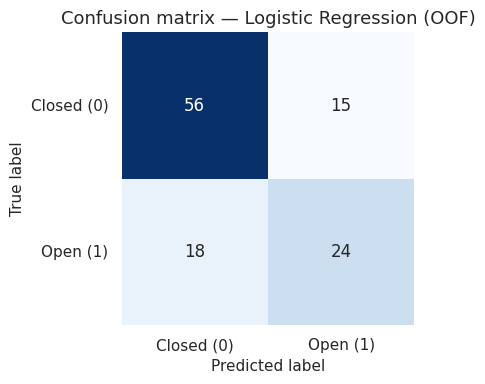

#### Classification report (OOF)

,precision,recall,f1-score,support
0,0.757,0.789,0.772,71.000
1,0.615,0.571,0.593,42.000
accuracy,0.708,0.708,0.708,0.708
macro avg,0.686,0.680,0.683,113.000
weighted avg,0.704,0.708,0.706,113.000


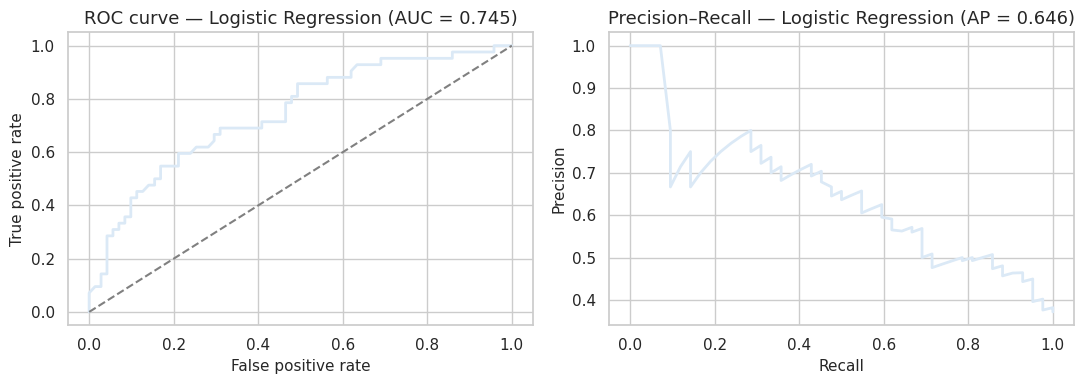

In [9]:
display(Markdown(f"### Detailed evaluation — {best_name} (OOF predictions)"))

# Confusion matrix
cm = confusion_matrix(y, best_oof_pred, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=["True Closed (0)", "True Open (1)"],
    columns=["Pred Closed (0)", "Pred Open (1)"],
)

display(Markdown("#### Confusion matrix (OOF)"))
display(cm_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.title(f"Confusion matrix — {best_name} (OOF)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["Closed (0)", "Open (1)"])
plt.yticks([0.5, 1.5], ["Closed (0)", "Open (1)"], rotation=0)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y, best_oof_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T
display(Markdown("#### Classification report (OOF)"))
display(report_df.round(3).style.background_gradient(cmap="Blues").format("{:.3f}"))

# ROC & PR curves (if probabilities are available)
if np.unique(best_oof_proba).size > 1:
    try:
        roc_auc = roc_auc_score(y, best_oof_proba)
    except ValueError:
        roc_auc = np.nan

    fpr, tpr, _ = roc_curve(y, best_oof_proba)
    prec, rec, _ = precision_recall_curve(y, best_oof_proba)
    ap = average_precision_score(y, best_oof_proba)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))

    # ROC
    ax[0].plot(fpr, tpr, lw=2)
    ax[0].plot([0, 1], [0, 1], ls="--", color="gray")
    ax[0].set_title(f"ROC curve — {best_name} (AUC = {roc_auc:.3f})")
    ax[0].set_xlabel("False positive rate")
    ax[0].set_ylabel("True positive rate")

    # PR
    ax[1].plot(rec, prec, lw=2)
    ax[1].set_title(f"Precision–Recall — {best_name} (AP = {ap:.3f})")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()

## 9. What drives openness? — feature importance

To move from **scores** to **explanations**, we inspect which features the best model relies on most.

We recover the post-encoding feature names and rank them by importance / coefficient magnitude  
to surface the strongest signals for `open_source`.


### Feature importance — drivers of openness

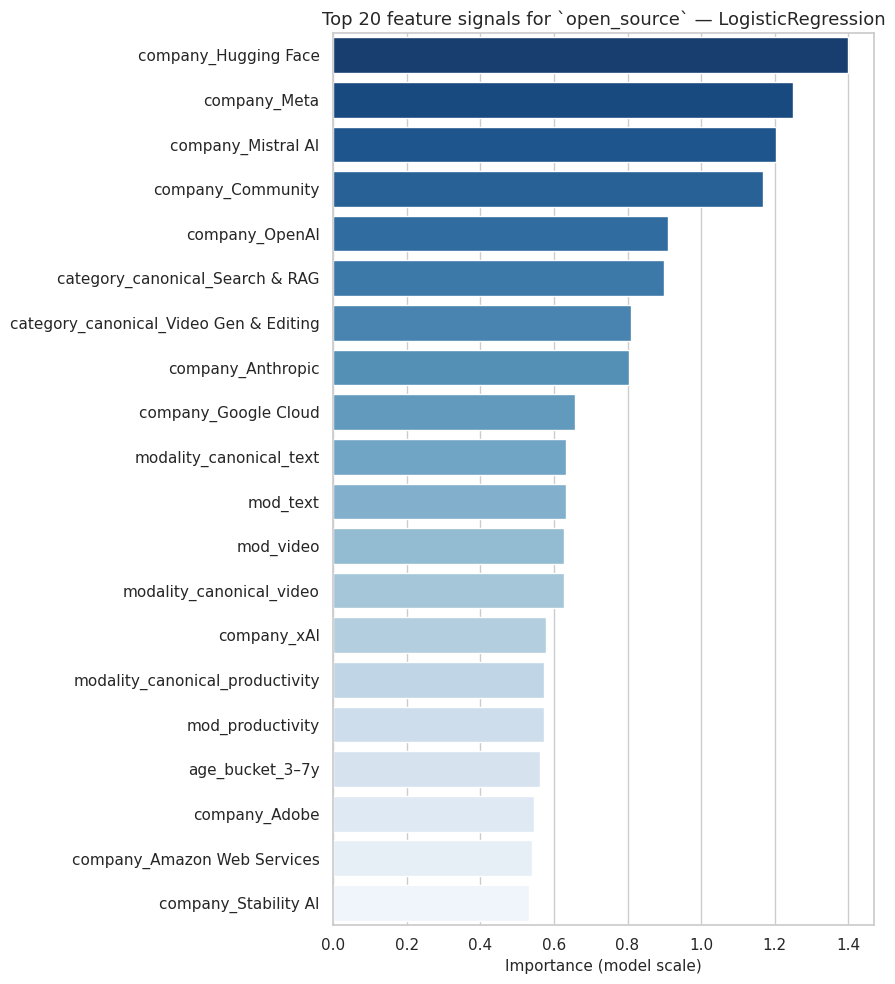

**Most influential signals (top rows have the strongest impact on `open_source`):**

,feature,importance
0,company_Hugging Face,1.399491
1,company_Meta,1.248125
2,company_Mistral AI,1.202114
3,company_Community,1.167816
4,company_OpenAI,0.908864
5,category_canonical_Search & RAG,0.900173
6,category_canonical_Video Gen & Editing,0.809180
7,company_Anthropic,0.803912
8,company_Google Cloud,0.656856
9,modality_canonical_text,0.632308


In [10]:
def get_feature_names_from_preprocessor(
    preprocessor: ColumnTransformer,
    numeric_features: list,
    categorical_features: list,
) -> list:
    """Return a flat list of feature names after preprocessing."""
    feature_names = []

    if numeric_features:
        feature_names.extend(numeric_features)

    if categorical_features and "cat" in preprocessor.named_transformers_:
        cat_ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
        try:
            cat_names = cat_ohe.get_feature_names_out(categorical_features)
        except TypeError:
            cat_names = cat_ohe.get_feature_names(categorical_features)
        feature_names.extend(list(cat_names))

    return feature_names


def plot_feature_importance(
    pipeline: Pipeline,
    numeric_features: list,
    categorical_features: list,
    top_n: int = 20,
) -> None:
    """Plot feature importance (tree-based) or absolute coefficients (linear)."""
    clf = pipeline.named_steps.get("clf", None)
    prep = pipeline.named_steps.get("prep", None)

    if clf is None or prep is None:
        print("No clf or prep step found in pipeline — skipping importance.")
        return

    feature_names = get_feature_names_from_preprocessor(
        prep, numeric_features, categorical_features
    )

    importances = None
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        coef = clf.coef_
        if coef.ndim == 1:
            importances = np.abs(coef)
        else:
            importances = np.abs(coef).mean(axis=0)

    if importances is None:
        print("Model does not expose feature_importances_ or coef_ — skipping.")
        return

    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(top_n)

    plt.figure(figsize=(9, min(0.4 * top_n + 2, 12)))
    sns.barplot(data=fi, x="importance", y="feature", palette="Blues_r")
    plt.title(f"Top {top_n} feature signals for `open_source` — {type(clf).__name__}")
    plt.xlabel("Importance (model scale)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    display(Markdown("**Most influential signals (top rows have the strongest impact on `open_source`):**"))
    display(fi.reset_index(drop=True))


display(Markdown("### Feature importance — drivers of openness"))
plot_feature_importance(best_model, numeric_features, categorical_features, top_n=20)

## 10. Summary & next steps

We started with a **catalog of Generative AI tools** and turned it into a focused analysis of openness in the 2025 GenAI ecosystem.

What we did:

- Cleaned and enriched the data with `modality_count`, `years_since_release`, and `age_bucket`, plus consistent binary flags for `open_source` and `api_available`  
- Mapped the ecosystem: release trends, dominant categories and modalities, openness patterns by year and category, and leading vendors  
- Defined a clear feature set (numeric + categorical) and trained three Stratified K-Fold baselines (Logistic Regression, Random Forest, HistGradientBoosting), selecting the best by **Macro-F1**  
- Evaluated the chosen model with OOF confusion matrix, ROC/PR curves, and feature importance to surface the strongest drivers of `open_source`

How this notebook can be reused:

- As a **template** for other catalog-style datasets (products, APIs, SaaS tools, research assets)  
- As a base for adding:
  - Cost-aware thresholding for open vs closed decisions  
  - Explainability (e.g. SHAP, partial dependence on key features)  
  - A lightweight Streamlit/dashboard front-end that exposes the EDA views and a “what-if” scorer for new tools
